#머신러닝 및 응용 7장 실습 코드
G202358021 안종혁

In [1]:
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()

#다수결 분류기
앙상블 학습은 여러 대의 예측기의 결과를 수집하여 종합한 후에 예측값을 정하는 학습법이며, 앙상블 학습 알고리즘을 앙상블 기법이라 부른다. 성능이 약한 학습기 여러 대를 앙상블 학습에 이용하면 (보다) 강력한 학습기를 생성할 수 있다. 전제 조건은 다음과 같다.

1. 학습기 사이의 독립성과 다양성이 보장되어야 한다.

2. 충분히 많은 학습기가 사용되어야 한다.

## 큰 수의 법칙

이에 대한 확률적 근거를 "51%의 확률로 앞면이 나오는 동전 1만 번 던지기"를 통해 설명할 수 있으며, 아래 코드가 모의실험을 실행한다.

'동전 1만 번 던지기를 10번 실행'한 결과는 (1만, 10) 모양의 넘파이 어레이를 무작위로 생성된 0과 1사이의 수를 이용하는 것으로 대신한다.


이어서 어레이의 각 항목을 0.51보다 작으면 True, 즉 앞면으로 간주한다.

Saving figure law_of_large_numbers_plot


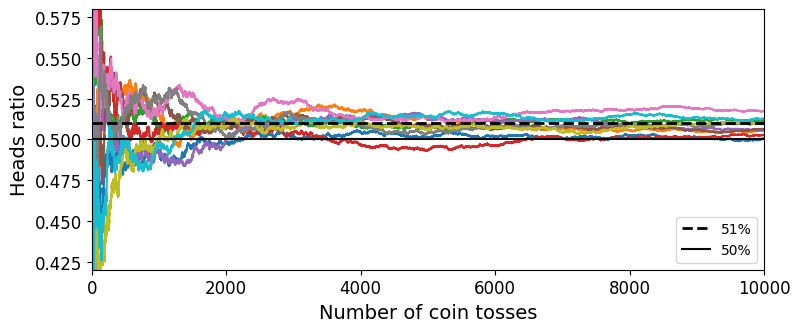

In [3]:
# 앞면이 나올 확률
heads_proba = 0.51

# 동전 1만번 던지기를 10번 실행한 결과. 0.51보다 작으면 True, 즉 앞면으로 간주함.
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

# 1만번 던질 때까지 각 단계에서 앞면이 나온 비율
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

#위 코드는 '1만번 던지기'를 10번 실행할 때 큰 수의 법칙에 의해서 앞면이 나올 확률이 50% 이상으로 수렴하는 사실을 보여준다.
plt.figure(figsize=(8,3.5))

# 10번의 모의실험 결과 그래프
plt.plot(cumulative_heads_ratio)
# 51% 수렴선
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
# 50% 경계선
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")

plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

위 모의 실험을 통패서 51%정확도의 분류기를 충분히 많이 사용하게 된다면 양성과 음성에 대한 정확도가 매우 높아질 수 있다는 것을 알 수 있게된다.
실제로 51%의 확률로 앞면이 나오는 동전을 1만 번 던졌을 때 앞면이 50% 이상 나올 학률은 97% 이상이며, 1천 번만 던져도 75% 정도로 앞면이 많이 나온다. 이를 51% 정확도의 분류기를 1만 번 또는 1천 번 실행해서 모은 예측값들 중에서 다수인 것을 선택하는 방식을 선택했을 때 각각 97% 이상과 75% 정도의 정확성을 갖는다는 것으로 이해할 수 있다.

위 확률을 이항분포를 이용하여 간단하게 계산할 수 있다.


In [4]:
from scipy.stats import binom

def ensemble_win_proba(n, p):
    """
    p: 예측기 하나의 성능
    n: 앙상블 크기, 즉 예측기 개수
    반환값: 다수결을 따를 때 성공할 확률. 이항 분포의 누적분포함수 활용.
    """

    return 1 - binom.cdf(int(n*0.499999), n, p)

In [5]:
ensemble_win_proba(1000, 0.51)
# 51%의 확률로 앞면이 나오는 동전을 1천 번 던져서 절반 이상 앞면이 나올 확률은 약 7.67%이다

0.7467502275563249

In [6]:
ensemble_win_proba(10000, 0.51)
# 이때 시행횟수를 만번으로 늘리면 확률이 97.7이상으로 나오게 된다.

0.9777976478701107

이때 정확도 80%의 이진분류기를 적게 이용하게 되면 앙상블 학습기의 성능이 유의미하게 높게  나온다.

앞선 전제를 만족하는 경우에 실전에서 최적으로 튜닝되어진 모델의 성능을 앙상블 학습을 통해서 개선하고자 하는 시도를 많이 한다.

In [7]:
ensemble_win_proba(10, 0.80)


0.9936306176

#직접 투표 vs 간접 투표
아래 코드는 여러 종류의 분류기를 앙상블로 묶어 훈련시키는 방법을 보여준다. 사용되는 훈련데이터는 moons 데이터셋이다.



In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##직접투표

VotingClassifier 모델은 여러 개의 분류기를 이용한 앙상블 학습 분류기를 지원한다. 사용되는 분류기는 로지스틱 회귀, 랜덤 포레스트 분류기, SVM이다.

In [9]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#voting='hard'는 분류기들의 다수 예측값을 예측값으로서 사용한다는 의미이다.
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


##간접투표

In [11]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


간접 투표 방식이 직접 투표 방식보다 정확도를 높힌다. default는 직접 투표이다.

#배깅과 페이스팅

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


밑에 코드는 의사결정나무 모델을 규제없이 사용할 때(왼)와 500개를 사용하는 배깅 분류기(오)의 성능을 비교하는 그래프를 그린다.

Saving figure decision_tree_without_and_with_bagging_plot


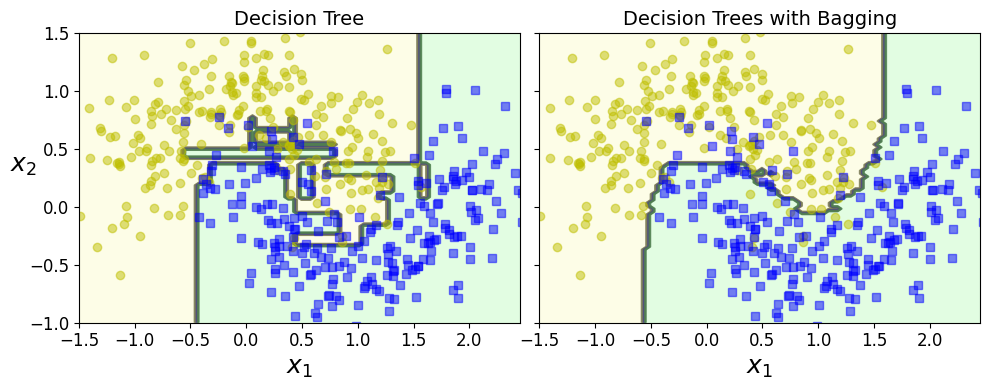

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

# 왼편 그림
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

# 오른편 그림
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

obb 평가

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.8986666666666666

In [18]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

테스트 성능과 유사한 결과를 보인다.


In [19]:
#처음 10개 훈련 샘플의 클래스 확률을 보이면 다음과 같다.
bag_clf.oob_decision_function_[:10]


array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637]])

#랜덤 포레스트
랜덤포레스트는 결정트리를 이용한 배깅 모델을 최적화한 결과를 기본적으로 이용한 모델이다.


In [20]:
#결정 트리를 이용한 배깅 모델
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
#랜덤포레스트 모델
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [22]:
#또한 두 모델의 예측값이 97%정도로 동일하다.
np.sum(y_pred == y_pred_rf) / len(y_pred)


0.976

아래 코드는 배깅 기법이 작동하는 방식을 보여준다.


결정트리 모델을 독립적으로 15번 훈련


max_samples=1.0, bootstrap=True 옵션 처럼 샘플 중복 선택 허용.


15개의 모델에 대해 결정경계를 희미하게 보여줌(참고: 배깅 모델의 경우 분류는 최빈값, 회귀는 평균값 사용).


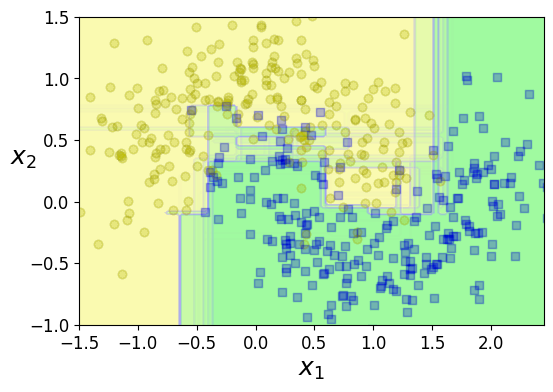

In [23]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

#특성 중요도
선택된 특성과 임계값의 중요도를 훈련과정을 통해서 측정하게 된다.

##붓꽃 특성 중요도
꽃잎의 길이와 너비가 가장 중요하다.

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


##MNIST 이미지의 특성 중요도

In [28]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)


In [29]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

Saving figure mnist_feature_importance_plot


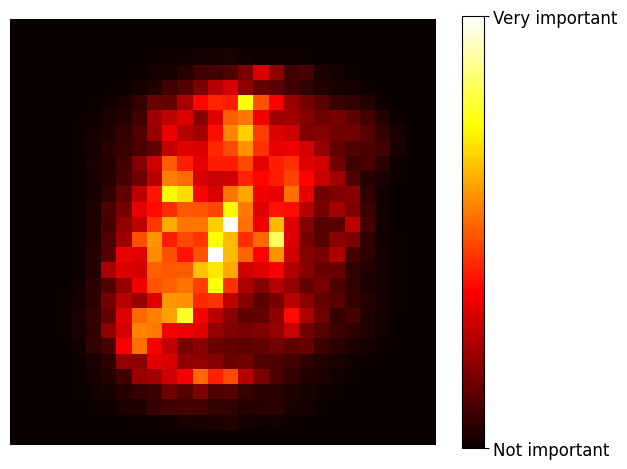

In [30]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

#부스팅


Saving figure boosting_plot


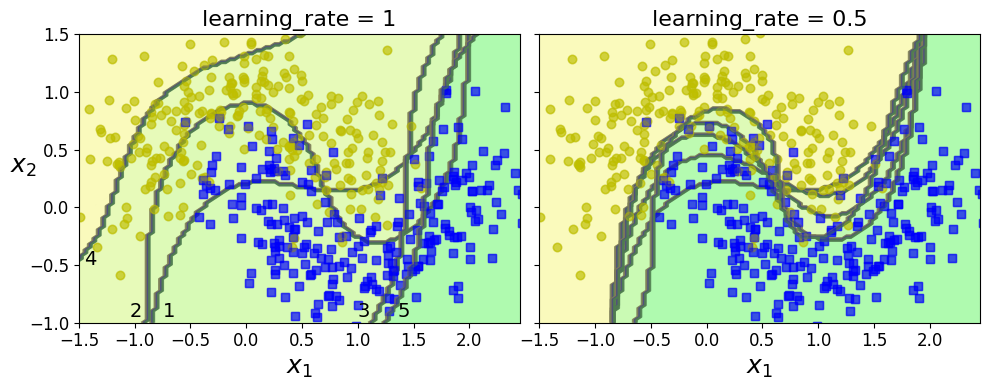

In [26]:
#moons 데이터셋에 rbf커널을 사용하는 svc모델을 5번 연속 학습한 결과를 보여준다.
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)  # 업데이트된 샘플 가중치 사용
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

사이킷런의 AdaBoostClassifier 모델을 활용하여 moons 데이터셋에 훈련시키면 다음과 같다.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


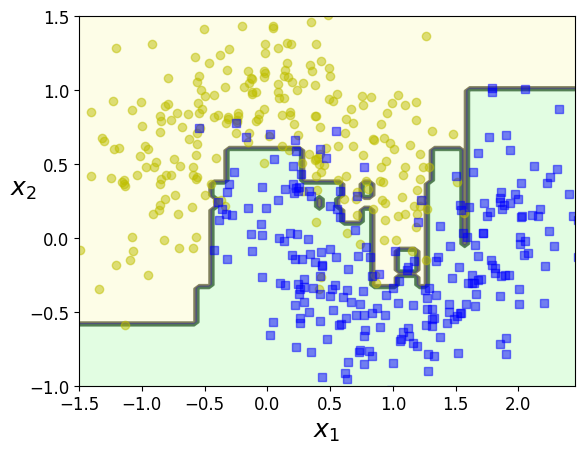

In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

그레디언트 부스팅

아래 코드는 잡음이 섞인 2차 함수 그래프 형태의 훈련 세트를 사용하여 그레이디언트 부스팅 기법을 회귀 모델 훈련에 적용하는 것을 보여준다.


순서는 다음과 같다.


1. 의사결정나무 모델을 훈련 시킨다.

2. 잔여오차에 대한 의사결정나무 모델을 훈련시킨다.

3. 한번 더 잔여오차에 대해 다시 의사결정나무 모델을 훈련시킨다.

4. 예측값은 사용된 예측기들의 예측값의 합이다.

In [32]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor
#1
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)
#2
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)
#3
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)
#4
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

아래 코드는 훈련시킨 세가지의 모델의 예측 성능을 그래프로 그린 코드이다.

* 좌변: 세 개의 예측기 각각의 예측 그래프

* 우변: 누적 예측 그래프

Saving figure gradient_boosting_plot


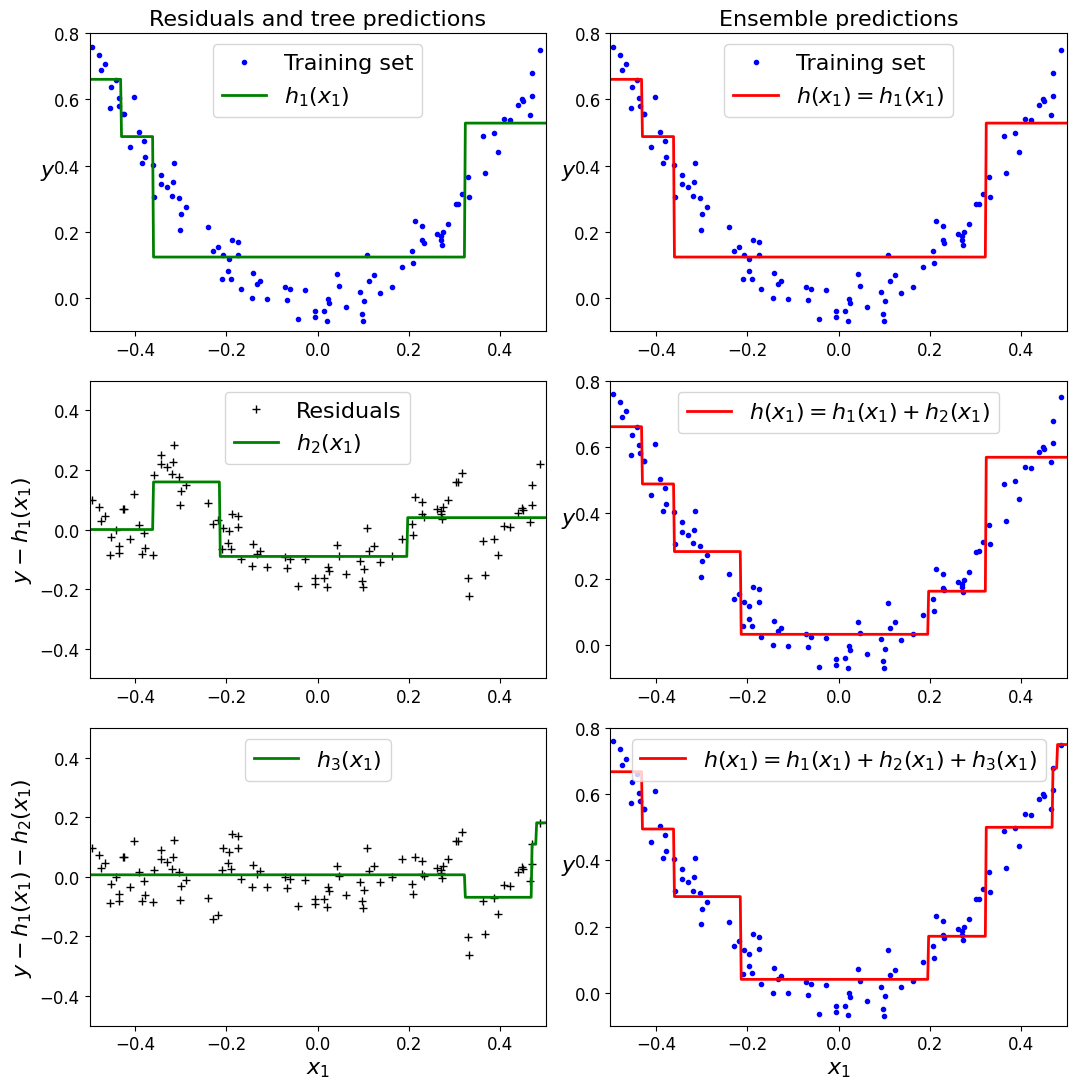

In [34]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)


plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

사이킷런의 GBRT 모델 활용

하이퍼 파라미터가 서로 다른 2개의 GradientBoostingRegressor 모델의 성능 차이를 본다.

이때 learning rate와 number of estimators를 1.0, 3(좌변)과 0.1, 200(우변) 두가지로 하여 비교해 보려하는 코드이다.

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [36]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


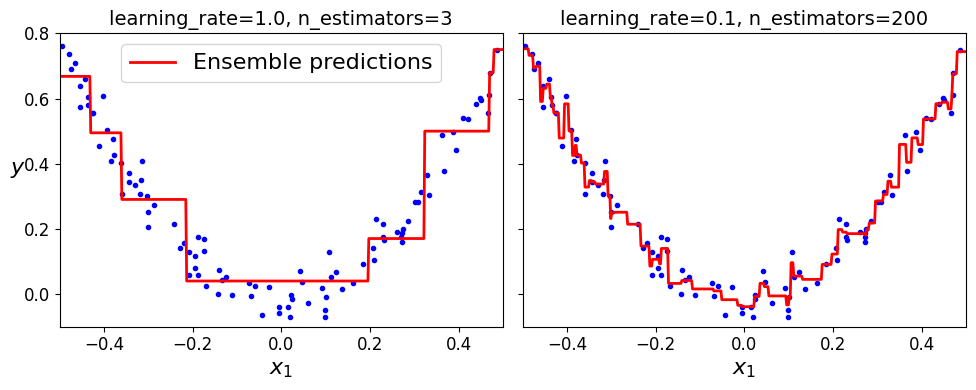

In [37]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

# 좌변 그래프
plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# 우변 그래프
plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

조기종료를 사용하는 그레이디언트 부스팅

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

Saving figure early_stopping_gbrt_plot


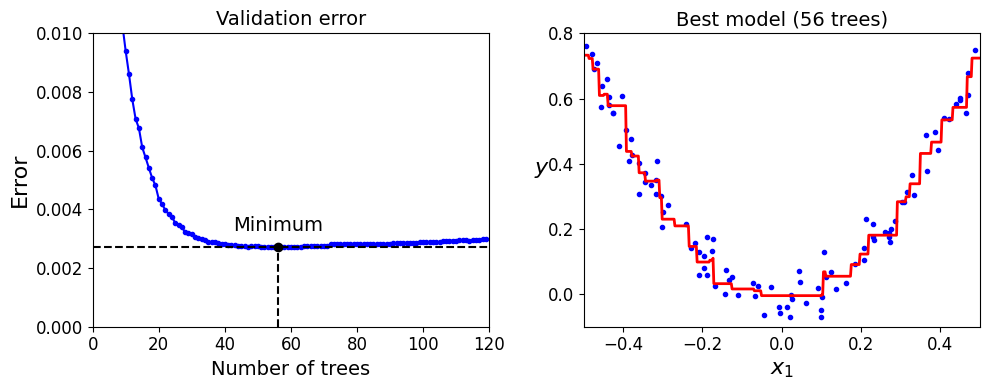

In [42]:
#위 코드는 120번 반복훈련을 한 후에 최적의 예측기 개수를 알아낸 이후 다시 훈련한 결과를 보이는 코드이다.
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

# 왼편: 평균제곱근오차 그래프
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

# 오른편: 최적의 예측기 개수를 이용하여 다시 훈련된 모델
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [43]:
#아래 코드는 평균제곱근오차가 5번 이상 개선되지 않을 때 훈련을 조기종료하도록 한다.

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [44]:
print(gbrt.n_estimators)
# 사용한 예측기의 개수

61


In [45]:
print("Minimum validation MSE:", min_val_error)
# 훈련 중 얻은 MSE의 최소값

Minimum validation MSE: 0.002712853325235463


#스태킹

스태킹 회귀이며 사이킷런에 StackingRegressor 모델을 사용하며 위 모델의 훈련에 사용하는 데이터셋은 사이킷런의 혈당 관련 데이터를 사용한다.

In [46]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('knr', KNeighborsRegressor(n_neighbors=20,
                                          metric='euclidean'))]

final_estimator = GradientBoostingRegressor(
    n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
    random_state=42)

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator)

In [47]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)
X.shape

(442, 10)

예측값은 1년 뒤의 당뇨병의 병변 진행도이다.

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
y_pred[:5]

array([136.02951253, 157.01444516, 145.74897537, 248.04682829,
       135.80610186])

In [49]:
reg.transform(X_test[:5])
#transform을 통해서 훈련에 사용된 예측기별 예측값을 반환하여 볼 수 있다.

array([[142.36209608, 138.30724927, 146.1       ],
       [179.700576  , 182.89812552, 151.75      ],
       [139.89817956, 132.46803343, 158.25      ],
       [286.95180286, 292.65695767, 225.4       ],
       [126.88317154, 124.1215975 , 164.65      ]])

##다층 스태킹 회귀

In [50]:
from sklearn.ensemble import RandomForestRegressor

final_layer_rfr = RandomForestRegressor(
    n_estimators=10, max_features=1, max_leaf_nodes=5,random_state=42)

final_layer_gbr = GradientBoostingRegressor(
    n_estimators=10, max_features=1, max_leaf_nodes=5,random_state=42)

final_layer = StackingRegressor(
    estimators=[('rf', final_layer_rfr),
                ('gbrt', final_layer_gbr)],
    final_estimator=RidgeCV()
    )

multi_layer_regressor = StackingRegressor(
    estimators=[('ridge', RidgeCV()),
                ('lasso', LassoCV(random_state=42)),
                ('knr', KNeighborsRegressor(n_neighbors=20,
                                            metric='euclidean'))],
    final_estimator=final_layer
)

multi_layer_regressor.fit(X_train, y_train)

y_pred = multi_layer_regressor.predict(X_test)
y_pred[:5]

array([137.07934614, 165.35618425, 146.08682283, 258.59303757,
       133.38482956])

In [ ]:
multi_layer_regressor.transform(X_test[:5])


#스태킹 분류

사이킷런의 StackingClassifier 모델을 사용한다. 위 예제에서는 iris data를 사용하였다.

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

In [52]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

clf.fit(X_train, y_train).score(X_test, y_test)


0.9473684210526315